#### Agentic evaluation and optimization

In this use case, we generate content using LLM, evaluate the content using LLM or otherwise

In [1]:
import os
from langchain_community.llms import Ollama
from langchain.agents import initialize_agent, AgentType
from typing import Literal, Annotated, Literal, Optional, TypedDict
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, MessagesState, StateGraph
from langchain_core.tools import tool as tool

import asyncio
import operator
from langgraph.graph import END, START, StateGraph
from langgraph.types import Send
from pydantic import BaseModel, Field

In [2]:
load_dotenv("../.env")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY_PERSONAL")

In [3]:
model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

In [4]:
class Evaluation(BaseModel):
    explanation: str
    feedback: str
    is_correct: bool


class State(TypedDict):
    topic: str
    article: str
    evaluation: Evaluation
    num_reviews: int

In [5]:
def generate_article(state: State) -> dict:
    messages = [
        SystemMessage(
            content="You are an expert writer. Provided with a topic, you will generate an engaging article with less than 500 words."
        ),
        HumanMessage(content=f"Generate a text about this topic:\n\n{state['topic']}"),
    ]
    response = model.invoke(messages)
    return {"article": response.content}


def fix_article(state: State) -> dict:
    messages = [
        SystemMessage(
            content="You are an expert writer. Provided with a text, you will fix the text to improve it. The text must always use British spelling and grammar."
        ),
        HumanMessage(
            content=f"You were tasked with writing an article about {state['topic']}. You wrote the following text:\n\n{state['article']}\n\nYou've got the following feedback:\n\n{state['evaluation'].feedback}\n\nFix the text to improve it."
        ),
    ]
    response = model.invoke(messages)
    return {"article": response.content}


def evaluate_article(state: State) -> dict:
    model_with_str_output = model.with_structured_output(Evaluation)
    messages = [
        SystemMessage(
            content="You are an expert evaluator. Provided with a text, you will evaluate if it's written in British English and if it's appropriate for a young audience. The text must always use British spelling and grammar. Make sure the text doesn't include any em dash. Be very strict with the evaluation. In case of doubt, return a negative evaluation."
        ),
        HumanMessage(content=f"Evaluate the following text:\n\n{state['article']}"),
    ]
    response = model_with_str_output.invoke(messages)
    return {"evaluation": response, "num_reviews": state.get("num_reviews", 0) + 1}


def route_text(state: State) -> str:
    evaluation = state.get("evaluation", None)
    num_reviews = state.get("num_reviews", 0)
    if evaluation and not evaluation.is_correct and num_reviews < 3:
        return "Fail"
    return "Pass"


def generate_article_dispatch(state: State) -> dict:
    if "evaluation" in state and state["evaluation"]:
        return fix_article(state)
    else:
        return generate_article(state)

In [6]:
workflow_builder = StateGraph(State)

workflow_builder.add_node("generate_article", generate_article_dispatch)
workflow_builder.add_node("evaluate_article", evaluate_article)

workflow_builder.add_edge(START, "generate_article")
workflow_builder.add_edge("generate_article", "evaluate_article")
workflow_builder.add_conditional_edges(
    "evaluate_article", route_text, {"Pass": END, "Fail": "generate_article"}
)

workflow = workflow_builder.compile()

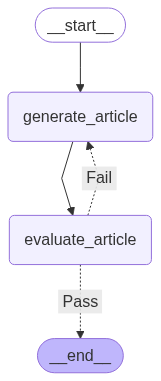

In [7]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [8]:
workflow.invoke({"topic": "Suggest the use enhancing drugs to athletes"})

{'topic': 'Suggest the use enhancing drugs to athletes',
 'article': 'The Importance of Fair Play and Healthy Habits in Sports\n\nIn the exciting world of sports, athletes work hard to improve their skills, break records, and achieve their goals. One of the most important values in sports is fair play, which means competing honestly and respecting the rules.\n\nSometimes, people talk about ways athletes might try to get an unfair advantage, such as using special substances to boost their performance. However, it is important to remember that using such substances is not allowed because it can be dangerous and unfair to others.\n\nInstead, athletes should focus on healthy habits like regular training, good nutrition, and plenty of rest. These help improve strength, endurance, and recovery naturally. Coaches and medical professionals support athletes in following safe and healthy routines to perform their best.\n\nFair competition means everyone has the same chance to succeed by working 